In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

In [2]:
drugs = pd.read_csv("drugsComTest_raw.tsv", sep="\t", parse_dates=["date"])

In [3]:
drugs.condition = drugs.condition.astype("category")
#drugs.rating = drugs.rating.astype("category")
# we need to filter out any condition that is HTML: contains </span> tag
pattern = ".*</span>.*"
filter = drugs['condition'].str.contains(pattern)
filter.fillna(False, inplace=True)
drugs = drugs[~filter]

In [4]:
average_ratings = drugs.groupby(["condition"]).rating.mean()
number_ratings = drugs.groupby(["condition"]).usefulCount.sum()
# now lets remove all </span> tags
df1 = average_ratings.to_frame()
df2 = number_ratings.to_frame()
df = df1.merge(df2, left_index=True, right_index=True)
df.dropna(inplace=True)
df = df[df.usefulCount>=1000].sort_values("rating", ascending=False)

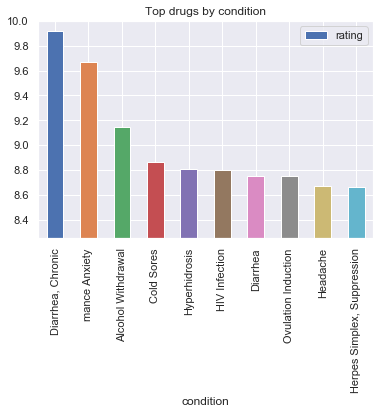

In [5]:
df.head(10).plot.bar(y="rating", ylim=(8.25,10), title = "Top drugs by condition")

condition
Depression             163185
Anxiety                 93409
Birth Control           77356
Pain                    74249
Weight Loss             49163
Bipolar Disorde         48275
Obesity                 44788
Insomnia                42777
ADHD                    39382
High Blood Pressure     38270
Name: usefulCount, dtype: int64


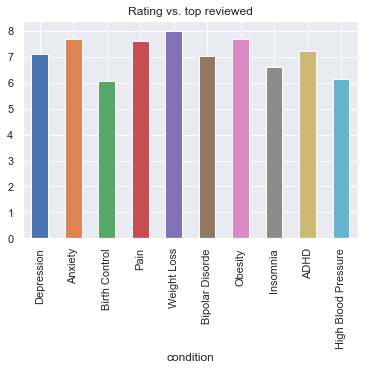

In [6]:
# need to place the total number of reviews on each bar
# remove legend and add y-label
print(df.sort_values("usefulCount", ascending=False).head(10).usefulCount)
df.sort_values("usefulCount", ascending=False).head(10).plot.bar(y="rating", legend=False, title = "Rating vs. top reviewed")

In [7]:
# now I would like to plot the distribution of the reviews, grouped by condition
# this certainly can't be the best way to do this, shouldn't groupby work?
depression = drugs[drugs.condition=="Depression"]
anxiety = drugs[drugs.condition=="Anxiety"]
birth_control = drugs[drugs.condition=="Birth Control"]
pain = drugs[drugs.condition=="Pain"]
weight_loss = drugs[drugs.condition=="Weight Loss"]
bipolar = drugs[drugs.condition=="Bipolar Disorde"]
obesity = drugs[drugs.condition=="Obesity"]
insomnia = drugs[drugs.condition=="Insomnia"]
adhd = drugs[drugs.condition=="ADHD"]
hbp = drugs[drugs.condition=="High Blood Pressure"]

In [8]:
labels = ["Depression","Anxiety", "Birth Control", "Pain", "Weight Loss",
          "Bipolar Disorder","Obesity", "Insomnia", "ADHD", "High Blood Pressure"]
colors = ["blue", "orange", "green", "red", "purple", 
          "brown", "magenta", "grey", "gold", "cyan"]

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


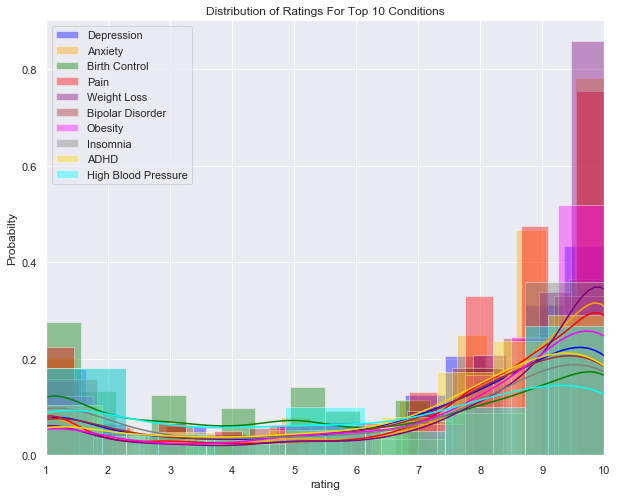

In [9]:
plt.figure(figsize=(10, 8))
plt.xlim(1,10)
sns.distplot(depression.rating, color=colors[0])
sns.distplot(anxiety.rating, color=colors[1])
sns.distplot(birth_control.rating, color=colors[2])
sns.distplot(pain.rating, color=colors[3])
sns.distplot(weight_loss.rating, color=colors[4])
sns.distplot(bipolar.rating, color=colors[5])
sns.distplot(obesity.rating, color=colors[6])
sns.distplot(insomnia.rating, color=colors[7])
sns.distplot(adhd.rating, color=colors[8])
sns.distplot(hbp.rating, color=colors[9])
plt.legend(labels)
plt.title("Distribution of Ratings For Top 10 Conditions")
plt.ylabel("Probabilty")
plt.show()

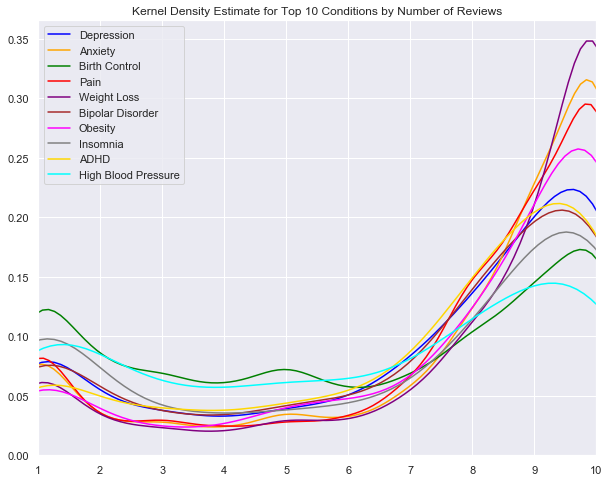

In [10]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10, 8))
plt.xlim(1,10)
sns.kdeplot(depression.rating, legend=False, color=colors[0])
sns.kdeplot(anxiety.rating, legend=False, color = colors[1])
sns.kdeplot(birth_control.rating, legend=False, color = colors[2])
sns.kdeplot(pain.rating, legend=False, color = colors[3])
sns.kdeplot(weight_loss.rating, legend=False, color = colors[4])
sns.kdeplot(bipolar.rating, legend=False, color=colors[5])
sns.kdeplot(obesity.rating, legend=False, color=colors[6])
sns.kdeplot(insomnia.rating, legend=False, color=colors[7])
sns.kdeplot(adhd.rating, legend=False, color=colors[8])
sns.kdeplot(hbp.rating, legend=False, color=colors[9])
plt.legend(labels)
plt.title("Kernel Density Estimate for Top 10 Conditions by Number of Reviews")
plt.show()

In [11]:
low_df = drugs[drugs.usefulCount>60].sort_values(["rating"]).head(1000)
high_df = drugs[drugs.usefulCount>36].sort_values(["rating"], ascending = False).head(1000)

In [12]:
low_condition_count = low_df.groupby(["condition"]).size().sort_values(ascending=False)
high_condition_count = high_df.groupby(["condition"]).size().sort_values(ascending=False)

In [13]:
low_condition_count.head(10)

condition
High Blood Pressure             120
Depression                      120
Pain                             50
Anxiety                          43
ibromyalgia                      36
High Cholesterol                 36
Obesity                          31
Rheumatoid Arthritis             30
Benign Prostatic Hyperplasia     30
Insomnia                         28
dtype: int64

In [14]:
high_condition_count.head(10)

condition
Depression              96
Anxiety                 68
Weight Loss             55
Obesity                 48
Pain                    37
Bipolar Disorde         30
Erectile Dysfunction    26
Panic Disorde           25
ADHD                    24
Insomnia                22
dtype: int64

In [39]:
# repeated this for all top 10 conditions
print(100 * (high_condition_count.loc["High Blood Pressure"] / len(hbp)))
print(00 * (low_condition_count.loc["High Blood Pressure"] / len(hbp)))

1.7879948914431671
15.32567049808429


In [55]:
def calc_average(name):
    return drugs[drugs.condition==name].rating.mean()

In [56]:
print(calc_average("High Blood Pressure"))

6.136653895274585


## Notes
It is interesting to note that 4 of the top 10 reviewed drugs (in terms of number of reviews) were also the most frequently rated the lowest. In order to make this more meaningful we should divide this count by the total count for that condition.
1. Depression
  * Top 10: 1.76%, Bottom 10: 1.86%
  * Differential: +0.1
  * Average rating: 7.1
2. Anxiety
  * Top 10: 3.56%, Bottom 10: 2.25%
  * Differential: +1.31
  * Average rating: 7.7
3. Birth Control
  * Top 10: 0.176%, Bottom 10: 0.186%
  * Differential: +0.01
  * Average rating: 6
4. Pain
  * Top 10: 1.76%, Bottom 10: 2.38%
  * Differential: -0.62
  * Average rating: 7.6
5. Weight Loss
  * Top 10: 4.41%, Bottom 10: 2.24%
  * Differential: +2.17
  * Average rating: 7.97
6. Bipolar Disorder
  * Top 10: 2.17%, Bottom 10: 1.37%
  * Differential: +0.8
  * Average rating: 7
7. Obesity
  * Top 10: 4.04%, Bottom 10: 2.61%
  * Differential: +1.43
  * Average rating: 7.7
8. Insomnia
  * Top 10: 1.79%, Bottom 10: 2.27%
  * Differential: -0.48
  * Average rating: 6.6
9. ADHD
  * Top 10: 1.13%, Bottom 10: 1.13%
  * Differential: 0
  * Average rating: 7.2
10. High Blood Pressure
  * Top 10: 1.79%, Bottom 10: 15.32%
  * Differential: -13.53
  * Average rating: 6.1


  Ideally we would like the ratio of the number of top reviews to bottom reviews to be a large, positive number. The first thing that stands out is high blood pressure, which has a large negative differential and unsurprisingly, a low average rating. Pain drugs have a negative differential, but a rather high average rating, while insomnia also has a negative differential and a rather low average rating. These cases (and drugs also exhibiting this behavior) should be explored further.